# Solving Ordinary Differential Equations with Neural Networks

*Based on the paper [Artificial Neural Networks for Solving Ordinary and Partial Differential Equations by I. E. Lagaris, A. Likas and D. I. Fotiadis(1997)](https://arxiv.org/abs/physics/9705023)*

## Problem 01

**Problem:** Find solution of 
$$
    \frac{du(x)}{dx} = \underbrace{- \frac{1}{5}u(x) + \exp(-\frac{1}{5}x) \cos(x)}_{=f(x, u(x))}
$$

with $u(0) = 0$ on the interval $[0,2]$. 

## Notation

$u_N$ denotes the **trial solution** of a neural network, that we will train in the following.

$u_a$ denotes the **analytic solution** or the *target function* of the ODE above. This is what our neural network should learn. The exact analytic solution of the ODE above reads 

$$
    u_a(x) = \exp(-\frac{1}{5}x)\sin(x) \tag{1}.
$$

## Key Idea

Write 

$$u_N(x) = x N_p(x),$$

where $N(x,p)$ is the neural network with training parameter $p$. We can easily see that

$$
    u_N(0) = 0 \cdot N_p(0) = 0.
$$

Thus, this ansatz satisfies the initial value condition. It just remains to adjust the parameter $p$ such that $u_N(x) = xN_p(x)$ approximates the target function $u_a$ for any $x \in [0,2]$ very well.

## Architecture of the Neural Network

We use a neural network with **one hidden layer** containing **$H=10$ neurons** and the **sigmoid function** as the activation function. The neural network has one single input layer and a single linear output layer.

## Training the Neural Network

Discretize $[0,2]$ such that we have a grid of $10$ equidistant points $x_1,...,x_{10} \in [0,2]$. Define the **loss function** as

$$
    E = \sum_{i=1}^{10} \left(\frac{d}{dx}u_N(x_i) - f(x_i, u_N(x_i))\right)^2,
$$

where $f$ is the right hand side of the ODE.

In [0]:
%matplotlib inline
%tensorflow_version 1.x 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [0]:
# domain of the solution
DOMAIN = [0.0, 2.0]

# number of neurons in the hidden layer
WIDTH = 10 

# number of discretization points/ number of training points
NUM_TRAINING_POINTS = 10

# number of neurons in the input layer
INPUT_DIMENSION = 1

# grid of equidistant points in the DOMAIN
TRAINING_POINTS = xs = np.linspace(DOMAIN[0], DOMAIN[1], NUM_TRAINING_POINTS)

# see formula (1)
def target_func(x):
    return np.exp(-0.2*x)*np.sin(x)

Next, we construct our shallow neural network (one hidden layer).

In [0]:
# Xavier initializer initialozes the parameters of the neural network in a "smart" way
# One could also intialize all parameters from an uniform distribution 
initializer = tf.contrib.layers.xavier_initializer()

# Input layer
input = tf.placeholder(dtype=tf.float32, shape=(None, INPUT_DIMENSION, ), name="input")

# Batch size = dimension of the input layer
batch_size = tf.shape(input)[0]

# Hidden layer
W = tf.Variable(initializer((WIDTH, INPUT_DIMENSION)), dtype=tf.float32, name="W") # Weights first hidden layer
u = tf.Variable(initializer((WIDTH,)), dtype=tf.float32, name="u") # Bias
z = tf.matmul(tf.broadcast_to(W, [batch_size,WIDTH,INPUT_DIMENSION] ), tf.reshape(input, shape=[-1, INPUT_DIMENSION, 1]))
z = z + tf.reshape(u, shape=(WIDTH, 1))
sigmoid_z = tf.nn.sigmoid(z)

# Single Output layer
v = tf.Variable(initializer((1,WIDTH)), dtype=tf.float32, name="v") # Weights output layer
output = tf.reshape(tf.matmul(tf.broadcast_to(v,[batch_size,1,WIDTH]), sigmoid_z), [-1,1,])

#----------------------------------------------

# right hand side of the ODE
f = tf.add(tf.multiply(-0.2,input*output),tf.multiply(tf.exp(tf.multiply(tf.constant(-0.2), input)),tf.cos(input)))

# compute the derivative of u
vW = tf.multiply(tf.reshape(W, [WIDTH]), v)
sigm = tf.multiply(tf.sigmoid(z), (1-tf.sigmoid(z)))
prod = tf.multiply(tf.reshape(vW, shape = (1, -1, 1)), sigm)
dN = tf.reduce_sum(prod, axis = 1)
dPsi = output + input* dN

# define the loss function
loss = tf.reduce_sum(tf.square(dPsi-f))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Training

Start training...
Training finished
Time elapsed: 7.445
Loss value: 0.00012377


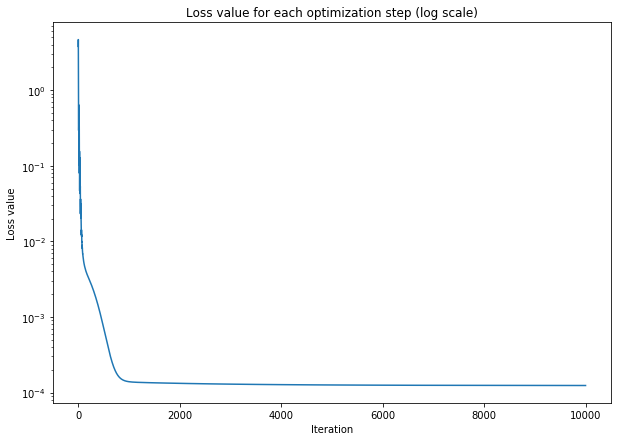

In [0]:
# Training parameters
#@markdown Number of training iterations
NUM_ITER = 10000 #@param {type:"integer"}
#@markdown Initial learning rate
INIT_L_RATE = 0.1 #@param {type:"number"}
#@markdown Final learning rate
FINAL_L_RATE = 1e-5 #@param {type:"number"}

# Holds the current number of training iterations
global_step = tf.Variable(0, trainable=False)

# Define the learning rate. 
#    - For example we could use a constant learning rate
#    - We use a decaying learning rate to get better training results
learning_rate = tf.train.exponential_decay(
    INIT_L_RATE,
    global_step,
    1,
    np.exp(np.log(FINAL_L_RATE/INIT_L_RATE) / NUM_ITER),
    staircase=True
)

# Apply any optimization algorithm, e.g. gradient descent
# AdamOptimizer is a stochastic gradient descent method
step = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step)

# Until now we've just defined the architecture of the neural network
# It's time to realize the neural network
session = tf.Session()
session.run(tf.global_variables_initializer())

# -----------------------
# Plotting
# -----------------------
ERROR_RATE = []
HISTORY = []

# Measure the time needed to train the neural network
t0 = time.time()

# Training phase
print('Start training...')
for i in range(NUM_ITER):
    # loss_val holds the training error after each iteration
    loss_val, _  = session.run(
        [loss, step],
        feed_dict={ 
            input: np.reshape(np.array(xs), (-1,1)) 
        }    
    )
    # save the training error to plot it later
    ERROR_RATE.append(loss_val)

    # save the graph of u_N after each iteration
    # later used to construct an animated gif 
    # that shows the convergence of u_N
    if (i % 5 == 0 and i<= 300):
        prediction = session.run(
            [output], 
            feed_dict={ 
                input: np.reshape(np.linspace(0,2,100), (-1,1))
            }
        )
        HISTORY.append(prediction)
print('Training finished')

# Plotting
plt.figure(figsize = (10,7))
plt.title("Loss value for each optimization step (log scale)")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.plot(ERROR_RATE)

print("Time elapsed: {:0.3f}".format(time.time() - t0))
print("Loss value: {:0.8f}".format(ERROR_RATE[-1]))

Compare the trial solution of the neural network with the target function.

Text(0.5, 1.0, 'Approximation error of $\\Psi_t$ and $\\Psi_a$')

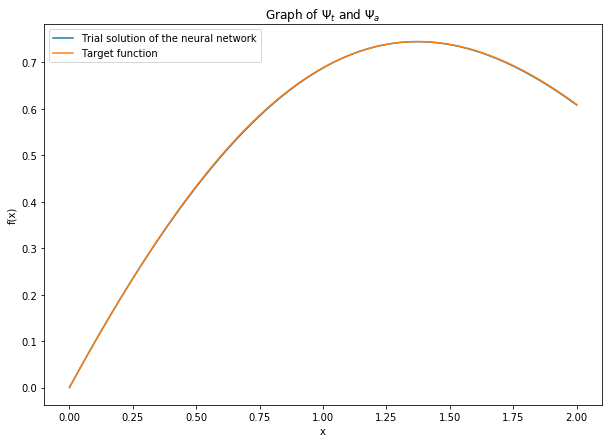

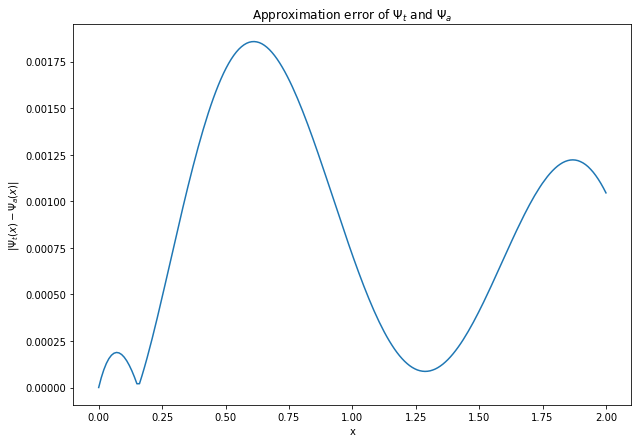

In [0]:
#@markdown Plots the functions from X_START to X_END
X_START = 0 #@param {type:"slider", min:-10, max:10, step:1}
X_END = 2 #@param {type:"slider", min:-10, max:10, step:1}
RESOLUTION = 200
xaxis = np.linspace(X_START,X_END,RESOLUTION)

# Plot the target function
target = target_func(xaxis)
# Plot u_N
prediction = np.reshape(session.run(output,
                        feed_dict={input: np.reshape(xaxis,(-1,1))}
                        ), (-1,)) * xaxis

plt.figure(0, figsize=(10,7))
plt.plot(xaxis, prediction, label="Trial solution of the neural network")
plt.plot(xaxis, target, label="Target function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Graph of $\Psi_t$ and $\Psi_a$")
plt.legend(loc=0)

plt.figure(1, figsize=(10,7))
plt.plot(xaxis, np.absolute(prediction-target))
plt.xlabel("x")
plt.ylabel("$|\Psi_t(x) - \Psi_a(x)|$")
plt.title("Approximation error of $\Psi_t$ and $\Psi_a$")

![alt text](https://s5.gifyu.com/images/problem-2-history.gif)


#END

In [0]:
'''
xaxis = np.linspace(0,2,100)
target = target_func(xaxis)

i = 0
for ys in HISTORY:
    fig = plt.figure(i,figsize=(10,7),dpi=300)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.axis([0.0,2.0,-0.4,1.0])
    plt.plot(xaxis, np.reshape(ys, (-1,))* xaxis, label="Iteration: {}. Error: {:0.2f}".format(5*i, ERROR_RATE[i*2]), linestyle=':', color='C0') 
    plt.plot(xaxis, target, label="Target function", color='C0')
    plt.legend(loc=1)
    plt.savefig('{}.png'.format(i))
    plt.close(fig)
    i = i + 1
'''

In [0]:
'''
!zip -r /content/file.zip /content/

from google.colab import files
files.download("/content/file.zip")
'''